In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [4]:
# import data
AAPL_data = pd.read_csv('./rsc/AAPL_data.csv')
# shift dates forward by one day
AAPL_data.dropna()
# correct calls and buys
# AAPL_test = np.where(AAPL_data['close'].shift(-1) > AAPL_data['close'],1,-1)
AAPL_test = AAPL_data['open'].shift(-1)
AAPL_data['Open-Close'] = AAPL_data.open - AAPL_data.close
AAPL_data['High-Low'] = AAPL_data.high - AAPL_data.low
# Drop date variable
AAPL_data = AAPL_data.drop(['date'], 1)
# Dimensions of dataset
n = AAPL_data.shape[0]
p = AAPL_data.shape[1]
print(n,p)

720 12


In [5]:
# renamed variables for easier access
AAPL_train = AAPL_data

In [6]:
# Make data a numpy array
AAPL_train = np.array(AAPL_data)
AAPL_test.head()

0    118.05
1    118.50
2    118.50
3    120.02
4    120.02
Name: open, dtype: float64

In [40]:
# Scale data
# scaler = MinMaxScaler()
# scaler.fit(AAPL_train)
# AAPL_train = scaler.transform(AAPL_train)
# scaler.fit(AAPL_test)
# AAPL_test = scaler.transform(AAPL_test)

# Training and test data
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = 0
test_end = int(np.floor(0.8*len(AAPL_test)))

# Build X and y
X_train = AAPL_train[train_start:train_end]
y_train = AAPL_test[test_start:test_end]
X_test = AAPL_train[train_end::]
y_test = AAPL_test[test_end::]

In [41]:
n_stocks = X_train.shape[1]
# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

In [42]:
# Model architecture parameters
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128
n_target = 1
# Layer 1: Variables for hidden weights and biases
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
# Layer 2: Variables for hidden weights and biases
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
# Layer 3: Variables for hidden weights and biases
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))
# Layer 4: Variables for hidden weights and biases
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

# Output layer: Variables for output weights and biases
W_out = tf.Variable(weight_initializer([n_neurons_4, n_target]))
bias_out = tf.Variable(bias_initializer([n_target]))

In [43]:
# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))

# Output layer (must be transposed)
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))
# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))
# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

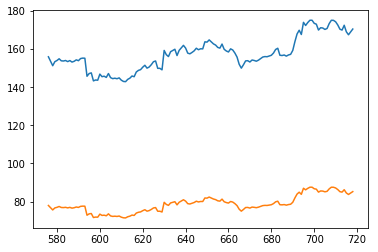

nan


In [44]:
# Make Session
net = tf.Session()
# Run initializer
net.run(tf.global_variables_initializer())

# Setup interactive plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test*0.5)
plt.show()

# Number of epochs and batch size
epochs = 10
batch_size = 256

for e in range(epochs):

    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

        # Show progress
#         if np.mod(i, 5) == 0:
#             # Prediction
#             pred = net.run(out, feed_dict={X: X_test})
#             line2.set_ydata(pred)
#             plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
#             file_name = 'img/epoch_' + str(e) + '_batch_' + str(i) + '.jpg'
#             plt.savefig(file_name)
#             plt.pause(0.01)
# Print final MSE after Training
mse_final = net.run(mse, feed_dict={X: X_test, Y: y_test})
print(mse_final)